Define the distance between two gates $V_1$ and $V_2$ as follows:
$$d(V_1,V_2) = \int_{\mathcal{H}} 1- \left| \langle \psi |V_2^\dagger V_1|\psi\rangle \right|^2 d\mu(\psi)$$
where the measure is Haar measure, i.e. the quantum state is sampled uniformly at random in the Hilbert space.

In [1]:
import qiskit
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, Clifford, random_clifford, random_unitary
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import unitary_group
import scipy
from qiskit.visualization import plot_bloch_vector
from scipy.linalg import orthogonal_procrustes
import pickle

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
%matplotlib notebook

In [2]:
def fidelity_gates_distance(num_samples, oper_1, oper_2, d_measure):
    V1, args1 = oper_1
    V2, args2 = oper_2
    
    distance = []
    
    for i in range(num_samples):
        
        vec = random_statevector(2) # sample random state by Haar measure
        #print('before circuit: {}'.format(vec)) 

        qc_1 = QuantumCircuit(1)
        getattr(qc_1, V1)(*args1)
        #print(qc_1.draw())
        new_vec_1 = vec.evolve(qc_1)
        #print('after circuit 1: {}'.format(new_vec_1))

        qc_2 = QuantumCircuit(1)
        getattr(qc_2, V2)(*args2)
        #print(qc_2.draw())
        new_vec_2 = vec.evolve(qc_2)
        #print('after circuit 2: {}'.format(new_vec_2))

        fidelity = min(state_fidelity(new_vec_1, new_vec_2), 1.) # avoid numerical problem
        
        if d_measure == 'bures':
            distance.append(1 - fidelity)
        if d_measure == 'f-s': #fubini-study metric
            distance.append(np.arccos(fidelity**(1/2)))
    
    return np.mean(distance)

In [3]:
print(fidelity_gates_distance(1000, ('x',(0,)), ('y',(0,)), 'bures'))
print(fidelity_gates_distance(1000, ('x',(0,)), ('h',(0,)), 'bures'))
print(fidelity_gates_distance(1000, ('z',(0,)), ('t',(0,)), 'bures'))
print(fidelity_gates_distance(1000, ('x',(0,)), ('x',(0,)), 'bures'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(fidelity_gates_distance(100, ('rx',[theta,0]), ('y',(0,)), 'bures'))
print("rx-y", np.mean(dist))

0.658184243089925
0.32648893253948486
0.5676630972535908
1.0014211682118912e-16
rx-y 0.6689070861388157


In [4]:
print(fidelity_gates_distance(1000, ('x',(0,)), ('y',(0,)), 'f-s'))
print(fidelity_gates_distance(1000, ('x',(0,)), ('h',(0,)), 'f-s'))
print(fidelity_gates_distance(1000, ('z',(0,)), ('t',(0,)), 'f-s'))
print(fidelity_gates_distance(1000, ('x',(0,)), ('x',(0,)), 'f-s'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(fidelity_gates_distance(100, ('rx',[theta,0]), ('y',(0,)), 'f-s'))
print("rx-y ", np.mean(dist))

0.9931261605250546
0.597144420527795
0.8542832012659207
5.297899193795793e-09
rx-y  0.997229276465684


We can write $|\psi\rangle = U|0\rangle$, where $U$ is a random unitary operator sampled according to Haar measure. Moreover, a unitary 2-design $\{U_j\}_{j=1}^k$ would satisfy
$$\frac{1}{K} \sum_{j=1}^K \left| \langle 0| U_j^\dagger V_2^\dagger V_1 U_j|0\rangle \right|^2 
= \int_{\mathcal{U}}\left| \langle 0| U^\dagger V_2^\dagger V_1 U|0\rangle \right|^2 d\mu(U)$$

There is one beautiful result saying that Clifford group (normalizers of Pauli group) constitute a unitary 3-design, thus also a unitary 2-design. For one-qubit, the Clifford group contains 24 elements, each a product of Hadamard gate and S gate. This allows us to compute exactly the average fidelity in a very efficient manner.

In [5]:
single_qubit_cliffords = [
 'i',
 'h', 's',
 'hs', 'sh', 'ss',
 'hsh', 'hss', 'shs', 'ssh', 'sss',
 'hshs', 'hssh', 'hsss', 'shss', 'sshs',
 'hshss', 'hsshs', 'shssh', 'shsss', 'sshss',
 'hshssh', 'hshsss', 'hsshss'
]

single_qubit_cliffords = [
 'i',
 'h', 's',
 'hs', 'sh', 'ss',
 'hsh', 'hss', 'shs', 'ssh', 'sss',
 'hshs', 'hssh', 'hsss', 'shss', 'sshs',
 'hshss', 'hsshs', 'shssh', 'shsss', 'sshss',
 'hshssh', 'hshsss', 'hsshss'
]

# single_qubit_cliffords = [
#  'I',
#  'H', 'S',
#  'HS', 'SH', 'SS',
#  'HSH', 'HSS', 'SHS', 'SSH', 'SSS',
#  'HSHS', 'HSSH', 'HSSS', 'SHSS', 'SSHS',
#  'HSHSS', 'HSSHS', 'SHSSH', 'SHSSS', 'SSHSS',
#  'HSHSSH', 'HSHSSS', 'HSSHSS'
# ]

In [6]:
def apply_clifford_from_string(qc, clifford_string):
    for gate in clifford_string:
        #instr = (gate, qubit)
        #getattr(qc, instr[0])(instr[1])
        getattr(qc, gate)(qc.qubits)
    return qc
        
def apply_clifford(qc, clifford):

    if isinstance(clifford, str):
        apply_clifford_from_string(qc, clifford)
        
    else:
        cliff_circ = clifford.to_circuit()
        qc = qc.compose(cliff_circ)
    #print(qc.draw())
    return qc
        
        
def compute_gates_distance_clifford(num_qubits, oper_1, oper_2, cliffords, d_measure):
    
    V1, args1 = oper_1
    V2, args2 = oper_2
    
    clifford_distance = []
    
    for i in range(len(cliffords)):
        clifford_string = cliffords[i]
        #print(clifford_string)
        
        vec = Statevector.from_label('0'*num_qubits) # |0\rangle

        qc_1 = QuantumCircuit(num_qubits)
        qc_1 = apply_clifford(qc_1, clifford_string)
        getattr(qc_1, V1)(*args1)
        new_vec_1 = vec.evolve(qc_1)
        
        qc_2 = QuantumCircuit(num_qubits)
        qc_2 = apply_clifford(qc_2, clifford_string)
        getattr(qc_2, V2)(*args2)
        new_vec_2 = vec.evolve(qc_2)
        
        
        fidelity = min(state_fidelity(new_vec_1, new_vec_2), 1.)
        if d_measure == 'bures':
            clifford_distance.append(1 - fidelity)
        if d_measure == 'f-s':
            clifford_distance.append(np.arccos(fidelity**(1/2)))
        
    return np.mean(clifford_distance)

In [7]:
print(compute_gates_distance_clifford(1, ('x', (0,)), ('y', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('h', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('z', (0,)), ('t', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('x', (0,)), single_qubit_cliffords, 'bures'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(compute_gates_distance_clifford(1, ('rx',[theta,0]), ('y',(0,)), single_qubit_cliffords, 'bures'))
print("rx-y ", np.mean(dist))

0.6666666666666669
0.3333333333333337
0.5690355937288493
5.366077952354923e-16
rx-y  0.6666666666666672


In [8]:
print(compute_gates_distance_clifford(1, ('x', (0,)), ('y', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('h', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('z', (0,)), ('t', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('x', (0,)), single_qubit_cliffords, 'f-s'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(compute_gates_distance_clifford(1, ('rx',[theta,0]), ('y',(0,)), single_qubit_cliffords, 'f-s'))
print("rx-y ", np.mean(dist))

1.0471975561636515
0.5235987838604563
0.785398168364502
2.083452367913229e-08
rx-y  1.0471975513589102


In [35]:
def state_to_cartesian(state):
    ket = state
    bra = ket.conj()
    rho = np.outer(ket,bra)
    
    z = (2*rho[0,0] - 1)
    x = rho[0,1] + rho[1,0]
    y = (rho[1,0] - rho[0,1])/1j
    
#     print(state)
#     print(rho)
#     print(x.real, y.real, z.real)
    return [x.real,y.real,z.real]

In [71]:
def get_state_spectrum(num_qubits, V, applied_qubits, thetas, cliffords):
    # get V(theta)C|0⟩ for various thetas.
    
    SINGLE_QUBIT_DETERMINISTIC_GATES = ['i', 'h', 's', 'x', 'y', 'z', 't']
    SINGLE_QUBIT_VARIATIONAL_GATES = ['rx', 'ry', 'rz']
    TWO_QUBIT_DETERMINISTIC_GATES = ['cx', 'cy', 'cz']
    TWO_QUBIT_VARIATIONAL_GATES = ['crx', 'cry', 'crz', 'rxx', 'ryy', 'rzz']
    
    output_states = np.zeros(shape=(len(cliffords), len(thetas), 2**num_qubits), dtype=np.complex_)
        
    vec = Statevector.from_label('0'*num_qubits) # |0\rangle
    
    for i,clifford in enumerate(cliffords): 
        qc = QuantumCircuit(num_qubits)
        cliff_circ = apply_clifford(qc, clifford)
        cliff_state = vec.evolve(qc)

        for j,theta in enumerate(thetas):
            var_V_circ = QuantumCircuit(num_qubits)
            if V in SINGLE_QUBIT_DETERMINISTIC_GATES: # one-qubit deterministic
                args = (*applied_qubits,)
            elif V in SINGLE_QUBIT_VARIATIONAL_GATES: # one-qubit variational
                args = (theta, *applied_qubits)
            elif V in TWO_QUBIT_DETERMINISTIC_GATES: # two-qubit deterministic
                args = (*applied_qubits,)
            elif V in TWO_QUBIT_VARIATIONAL_GATES: # two-qubit variational
                args = (theta, *applied_qubits)
            else:
                print("The input gate is not valid!")
                
            getattr(var_V_circ, V)(*args)  
            output_states[i,j] = cliff_state.evolve(var_V_circ).data
        
    return np.array(output_states)

In [72]:
with open('clifford_1qubits.pkl', 'rb') as inp:
    single_qubit_cliffords = pickle.load(inp)

eps = np.pi
samples = 5

distinct = [0,1,3,6,7,12]
distinct_cliffords = [single_qubit_cliffords[i] for i in distinct]
spectrum_3 = get_state_spectrum(2, 'rx', [0], np.linspace(-eps, eps, samples), distinct_cliffords)

spectrum_3 = to_state_format(spectrum_3)

#spectrum_rx = get_state_spectrum(1, 'rx', 0, np.linspace(-eps, eps, 5), single_qubit_cliffords)
#spectrum_ry = get_state_spectrum(1, 'ry', 0, np.linspace(-eps, eps, 5), single_qubit_cliffords)

In [73]:
spectrum_3

array([[[0.        -6.12323400e-17j, 1.        +0.00000000e+00j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [0.70710678+0.00000000e+00j, 0.        +7.07106781e-01j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [1.        +0.00000000e+00j, 0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [0.70710678+0.00000000e+00j, 0.        -7.07106781e-01j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [0.        +6.12323400e-17j, 1.        +0.00000000e+00j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],

       [[0.        -6.12323400e-17j, 1.        +0.00000000e+00j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [0.70710678+0.00000000e+00j, 0.        +7.07106781e-01j,
         0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
        [1.        +0.00000000e+00j, 0.        +0.00000000e+00j,
         0.     

In [11]:
def format_state(state):
    idx = next(i for i,ampl in enumerate(state) if abs(ampl) > 10e-9)
    unit_core = state[idx] / abs(state[idx]) # the exp(i*theta) part of the first nonzero element
    state = state * unit_core.conj() # cancel the core in the first nonzero element
    return state

def to_state_format(spectrum):
    shape = spectrum.shape
    spectrum = spectrum.reshape(-1,spectrum.shape[2])
    spectrum = np.apply_along_axis(format_state, 1, spectrum)
    spectrum = spectrum.reshape(shape)
    return spectrum

def perturb_phase(spectrum):
    shape = spectrum.shape
    rand_phase = np.random.rand(shape[0]*shape[1]) * 2*np.pi
    rand_cplx = np.exp(1j*rand_phase)
    rand_cplx = rand_cplx.reshape(shape[0],shape[1])
    spectrum = np.multiply(spectrum, rand_cplx[:,:, np.newaxis])
    return spectrum

In [61]:
eps = np.pi
samples = 100

distinct = [0,1,3,6,7,12]
distinct_cliffords = [single_qubit_cliffords[i] for i in distinct]
spectrum_1 = get_state_spectrum(1, 'rx', 0, np.linspace(-eps, eps, samples), distinct_cliffords)
spectrum_2 = get_state_spectrum(1, 'rz', 0, np.linspace(-eps, eps, samples), distinct_cliffords)

spectrum_1 = to_state_format(spectrum_1)
spectrum_2 = to_state_format(spectrum_2)

#spectrum_rx = get_state_spectrum(1, 'rx', 0, np.linspace(-eps, eps, 5), single_qubit_cliffords)
#spectrum_ry = get_state_spectrum(1, 'ry', 0, np.linspace(-eps, eps, 5), single_qubit_cliffords)

In [13]:
from scipy.optimize import linear_sum_assignment

def minimize_permutation(spectrum_A,spectrum_B,axis):
    
    print("Initial cost", np.linalg.norm(spectrum_B - spectrum_A)**2 / (spectrum_A.shape[0]*spectrum_A.shape[1]))
    
    spectrum_A = np.moveaxis(spectrum_A, axis,0)
    spectrum_B = np.moveaxis(spectrum_B, axis,0)
    
    cost_matrix = np.zeros(shape=(spectrum_A.shape[0], spectrum_B.shape[0]))
    for i in range(len(cost_matrix)):
        for j in range(len(cost_matrix)):
            cost_matrix[i,j] = np.linalg.norm(spectrum_B[i] - spectrum_A[j])**2 ## Row for B and Column for A
        
    row_ind, col_ind = linear_sum_assignment(cost_matrix) 
    
    
    permuted_spectrum_A = spectrum_A[col_ind]
    
    spectrum_A = np.moveaxis(spectrum_A, 0, axis)
    permuted_spectrum_A = np.moveaxis(permuted_spectrum_A, 0, axis)
    spectrum_B = np.moveaxis(spectrum_B, 0, axis)
    
    #print("Permutation difference", np.linalg.norm(spectrum_A - permuted_spectrum_A))
    print("Minimized cost", np.linalg.norm(spectrum_B - permuted_spectrum_A)**2 / (spectrum_A.shape[0]*spectrum_A.shape[1]))
    
    return permuted_spectrum_A, spectrum_B
    
def minimize_unitary(spectrum_A, spectrum_B):
    """
    Min |A x Omega - B|^2, where Omega is a unitary matrix
    """
    A = spectrum_A.reshape(-1,spectrum_A.shape[2])
    B = spectrum_B.reshape(-1,spectrum_B.shape[2])
    print("Initial cost", np.linalg.norm(B - A)**2 / A.shape[0])
    
    M = A.conj().T @ B
    U,Sigma,V_d = np.linalg.svd(M)
    rank = sum(Sigma > 10e-6) # =2

#     W = np.eye(U.shape[1], dtype=np.complex_)
#     if U.shape[1] - rank > 1:
#         W[rank:, rank:] = random_unitary(U.shape[1] - rank).spectrum
#     Omega = U @ W @ V_d # == U @ V_d
    Omega = U @ V_d
    
    transformed_A = A @ Omega
    transformed_spectrum_A = transformed_A.reshape(spectrum_A.shape[0],spectrum_A.shape[1],-1)

    #print("Unitary transform difference", np.linalg.norm(spectrum_A - transformed_spectrum_A))
    print("Minimized cost", np.linalg.norm(spectrum_B - transformed_spectrum_A)**2 /A.shape[0])
    
    return transformed_spectrum_A, spectrum_B

def minimize_unitary_lib(spectrum_A, spectrum_B):
    A = spectrum_A.reshape(-1,spectrum_A.shape[2])
    B = spectrum_B.reshape(-1,spectrum_B.shape[2])
    print("Initial cost", np.linalg.norm(B - A) / A.shape[0])
    
    Omega, scale = orthogonal_procrustes(A,B)
    
    transformed_A = A @ Omega
    print("Minimized cost before reshaping", np.linalg.norm(B - transformed_A))
    
    transformed_spectrum_A = transformed_A.reshape(spectrum_A.shape[0],spectrum_A.shape[1],-1)

    #print("Unitary transform difference", np.linalg.norm(spectrum_A - transformed_spectrum_A))
    print("Minimized cost", np.linalg.norm(spectrum_B - transformed_spectrum_A)/A.shape[0])
    print("\n")
    return transformed_spectrum_A, spectrum_B

In [14]:
n_anchors = 5
n_samples = 3
state_dim = 2
data = np.random.rand(n_anchors, n_samples, state_dim)

In [15]:
# data_A = data
 
# U = unitary_group.rvs(2)
# unitary_tf = lambda x: U@x

# data_B = np.apply_along_axis(unitary_tf, 2, data_A)
# data_B = data_B[:,np.random.permutation(data_B.shape[1]),:]
# data_B = data_B[np.random.permutation(data_B.shape[0])]

# data_A = to_state_format(data_A)
# data_B = to_state_format(data_B)

# curr_dist = 10e9
# min_dist = 10e9

# print("Start: ", np.linalg.norm(data_A - data_B)) # Euclidean norm

# for i in range(100):
#     #print('A = ', data_A)
#     #print('B = ', data_B)
#     data_A, data_B = minimize_permutation(data_A, data_B, axis=0)
#     data_A, data_B = minimize_permutation(data_A, data_B, axis=1)
    
    
#     new_dist = np.linalg.norm(data_A - data_B)
#     if abs(new_dist - curr_dist) < 10e-2 and new_dist > 10e-2:
#         print('Perturb...')
#         data_A = perturb_phase(data_A)        
#     curr_dist = new_dist
#     if curr_dist < min_dist:
#         min_dist = curr_dist
    
    
#     data_A, data_B = minimize_unitary(data_A, data_B)
    
#     data_A = to_state_format(data_A)

In [26]:
data_A, data_B = spectrum_1, spectrum_2
print(data_A.shape[0])
for i in range(30):
    
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[0]))
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[1]))
    data_A, data_B = minimize_permutation(data_A, data_B, axis=0)
    
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[0]))
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[1]))
    data_A, data_B = minimize_permutation(data_A, data_B, axis=1)
    
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[0]))
    print(np.linalg.norm(data_A-data_B)**2 / (1*data_A.shape[1]))
    data_A, data_B = minimize_unitary(data_A, data_B)
    
    data_A = to_state_format(data_A)

6
95.8083114605513
5.748498687633077
Initial cost 0.958083114605513
Minimized cost 0.5245191465077893
52.451914650778924
3.1471148790467356
Initial cost 0.5245191465077893
Minimized cost 0.5245191465077893
52.451914650778924
3.1471148790467356
Initial cost 0.5245191465077893
Minimized cost 0.5006873126822011
65.76320947245094
3.9457925683470565
Initial cost 0.6576320947245093
Minimized cost 0.6576320947245093
65.76320947245094
3.9457925683470565
Initial cost 0.6576320947245093
Minimized cost 0.647301179316758
64.7301179316758
3.8838070759005485
Initial cost 0.647301179316758
Minimized cost 0.5963008662801311
67.04069554981506
4.022441732988903
Initial cost 0.6704069554981505
Minimized cost 0.6704069554981505
67.04069554981506
4.022441732988903
Initial cost 0.6704069554981505
Minimized cost 0.670258993198601
67.0258993198601
4.021553959191606
Initial cost 0.670258993198601
Minimized cost 0.6498588767606654
66.81335365841382
4.008801219504829
Initial cost 0.6681335365841381
Minimized cos

Minimized cost 4.252293966396314e-24
4.252293966396314e-22
2.5513763798377882e-23
Initial cost 4.252293966396314e-24
Minimized cost 1.4174802499579104e-24
4.725518153667643e-23
2.8353108922005858e-24
Initial cost 4.725518153667643e-25
Minimized cost 4.725518153667643e-25
4.725518153667643e-23
2.8353108922005858e-24
Initial cost 4.725518153667643e-25
Minimized cost 4.725518153667643e-25
4.725518153667643e-23
2.8353108922005858e-24
Initial cost 4.725518153667643e-25
Minimized cost 1.5752966958748133e-25
5.252566377990418e-24
3.151539826794251e-25
Initial cost 5.252566377990418e-26
Minimized cost 5.252566377990418e-26
5.252566377990418e-24
3.151539826794251e-25
Initial cost 5.252566377990418e-26
Minimized cost 5.252566377990418e-26
5.252566377990418e-24
3.151539826794251e-25
Initial cost 5.252566377990418e-26
Minimized cost 1.7514278670896506e-26
5.84289779358698e-25
3.505738676152188e-26
Initial cost 5.842897793586981e-27
Minimized cost 5.842897793586981e-27
5.84289779358698e-25
3.505738

In [17]:
66.00000004241929
3.9600000025451574
Initial cost 0.6600000004241928
Minimized cost 0.6600000001065758

132.66666674874583
3.9800000024623743
Initial cost 0.663333333743729
Minimized cost 0.6633333334361877

SyntaxError: invalid syntax (850318844.py, line 3)

<IPython.core.display.Javascript object>


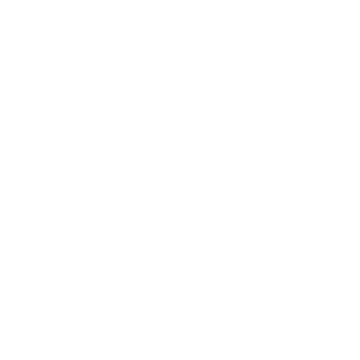

/Users/erio/opt/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:397: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])


<IPython.core.display.Javascript object>


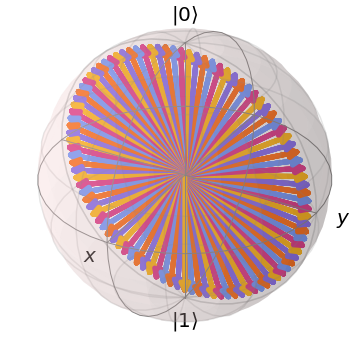

In [62]:
A = spectrum_1[:,:,:].reshape(-1,data_A.shape[2])
state_coor_A = [state_to_cartesian(state) for state in A]
plot_bloch_vector(state_coor_A, title="Bloch Sphere")

<IPython.core.display.Javascript object>


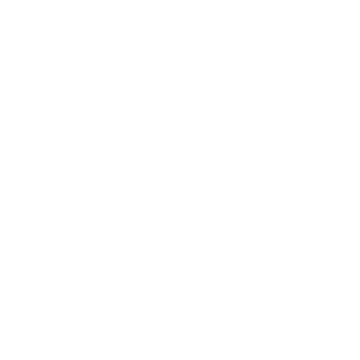

/Users/erio/opt/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/visualization/bloch.py:397: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])


In [65]:
B = spectrum_2[:,:,:].reshape(-1,data_B.shape[2])
state_coor_B = [state_to_cartesian(state) for state in B]
a = plot_bloch_vector(state_coor_B, title="Bloch Sphere")

In [ ]:
new_spectrum_rx[0:6,1,:]

In [ ]:
A_new = new_spectrum_rx[0:6,1,:].reshape(-1,new_spectrum_rx.shape[2])
state_coor_A_new = [state_to_cartesian(state) for state in A_new]
plot_bloch_vector(state_coor_A_new, title="Bloch Sphere")

In [ ]:
B = data_B[:,:,:].reshape(-1,data_B.shape[2])
state_coor_B = [state_to_cartesian(state) for state in B]
plot_bloch_vector(state_coor_B, title="Bloch Sphere")

The technique generalizes well for higher dimension. The Clifford group for 2 qubits has 11520 elements, and exponentially increases in the size for more qubits. As we restrict the set of gates to one-qubit and two-qubit gates, this should not be a problem. However, I'm still searching for an efficient way to compute distance involving one or more parametrized gates instead of fidelityimating
$$\frac{1}{m(\Theta_1) m(\Theta_2)} \int_{\mathcal{U}} \int_{\Theta_1, \Theta_2} \left| \langle 0| U^\dagger V_2^\dagger(\theta_2) V_1(\theta_1) U|0\rangle \right|^2 d\theta_1 d\theta_2 d\mu(U)$$
where $m(\Theta)$ is the measure of the parameter space.